# Model selection *using feed forward selection*

The model is au student model with gaussian prior, excpet sigma that has a gamma prior

$Y$~$t(X\theta , \sigma^2I_d , df)$ with as prior :
 - $\theta$~$N(0,\sigma_b^2I_p)$
 - $\sigma$~$Gamma(a,b)$

In [1]:
%matplotlib inline

from Baysian_framework import *
from Metropolis_hastings import *
from GVA import *
from Important_sampling import *

from Vizualisation_tool import *
from Model import *
from Model_torch import *

import seaborn as sns
import pandas as pd
import scipy as scp # optimization, probability densities and cumulative

In [2]:
df = pd.read_csv ('Real estate.csv')
# first drop usless variable 
data = df.drop(['No'],axis=1)

#Rename
data.rename(columns = {
                                'X1 transaction date': 'Date',
                                'X2 house age' : 'House_age',
                                'X3 distance to the nearest MRT station' : 'MRT_distance',
                                'X4 number of convenience stores' : 'Conv_store_count',
                                'X5 latitude' : 'Latitude',
                                'X6 longitude' : 'Longitude',
                                'Y house price of unit area' : 'Price_per_unit'
}, inplace = True)

X_names = [ 'Date' ,'House_age','MRT_distance','Conv_store_count','Latitude','Longitude' ]
Y_names = ['Price_per_unit' ]

data_tmp = data[data['Price_per_unit']<100]
data_no_outlier = data_tmp[data_tmp['Price_per_unit']>8]

#X= df[df.columns[1:-1]].to_numpy()

Y = (data_no_outlier['Price_per_unit']).to_numpy()

In [3]:
data_no_outlier['MRT_distance_sqrt'] = np.sqrt(data_no_outlier["MRT_distance"])

center_longitude_max = data_no_outlier['Longitude'][np.argmax(data_no_outlier['Price_per_unit'])]
center_latitude_max = data_no_outlier['Latitude'][np.argmax(data_no_outlier['Price_per_unit'])]
distance_center_vector_max = np.c_[data_no_outlier['Longitude'] - center_longitude_max,data_no_outlier['Latitude'] - center_latitude_max]
distance_vector_max = np.linalg.norm(distance_center_vector_max,axis=1)
orientation = np.arctan2(distance_center_vector_max[:,0],distance_center_vector_max[:,1])

data_no_outlier['dist_center'] = np.sqrt(distance_vector_max)
data_no_outlier['orientation'] = orientation





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [4]:
X_names = [ 'intercept', 'Date' ,'House_age','Conv_store_count','Latitude','Longitude', 'MRT_distance_sqrt' ,'dist_center','orientation','sigma','df' ]

### Model feed forward selection :

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:32<00:00, 107.53it/s]


Acceptance rate :  0.183
             features  Coeff   std                CI    2.5   25.0   50.0  \
0           intercept  36.49  0.33  [35.839, 37.145]  35.85  36.27  36.49   
1                Date   0.98  0.33    [0.330, 1.637]   0.34   0.77   0.98   
2           House_age  -3.38  0.37  [-4.107, -2.645]  -4.09  -3.64  -3.37   
3    Conv_store_count   1.03  0.57   [-0.117, 2.174]  -0.12   0.67   1.05   
4            Latitude   1.48  0.73    [0.012, 2.952]   0.09   1.03   1.45   
5           Longitude  -3.09  0.86  [-4.806, -1.366]  -4.88  -3.67  -3.07   
6   MRT_distance_sqrt  -7.38  0.82  [-9.024, -5.744]  -9.18  -7.91  -7.33   
7         dist_center  -2.38  0.99  [-4.362, -0.389]  -4.10  -3.13  -2.43   
8         orientation   1.88  0.69    [0.499, 3.261]   0.53   1.42   1.86   
9               sigma   5.00  0.34    [4.326, 5.681]   4.36   4.78   4.98   
10                 df   3.54  0.65    [2.245, 4.831]   2.46   3.10   3.48   

     75.0   97.5  
0   36.70  37.15  
1    1.21   

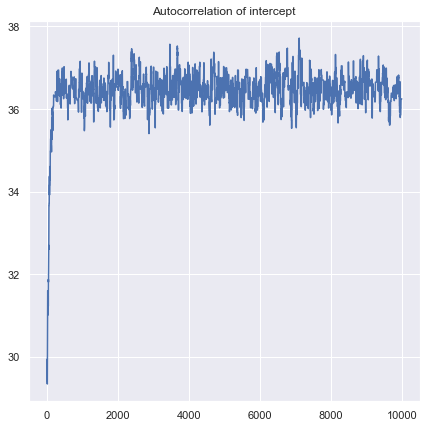

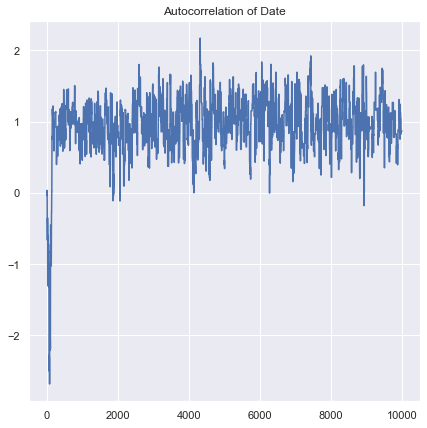

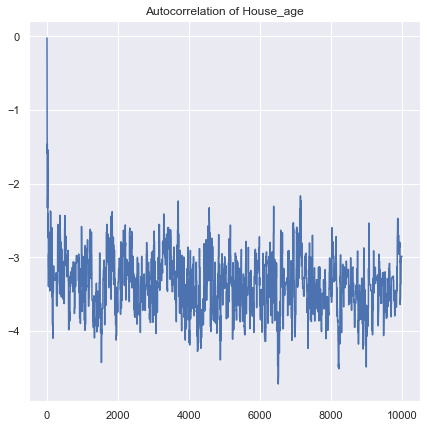

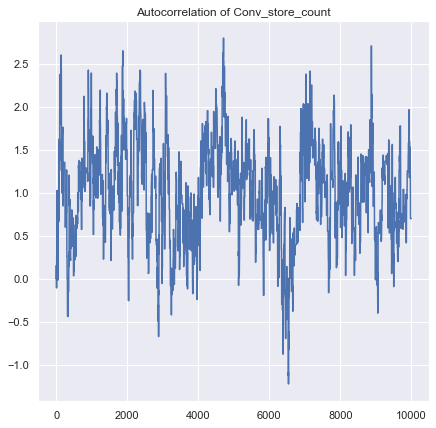

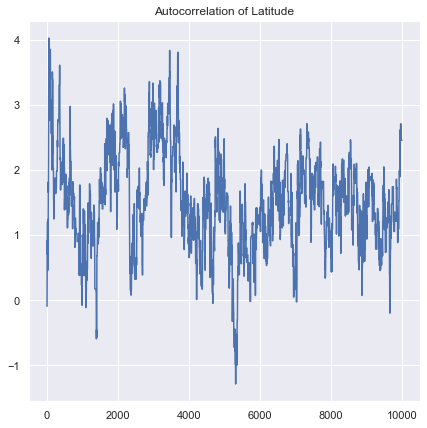

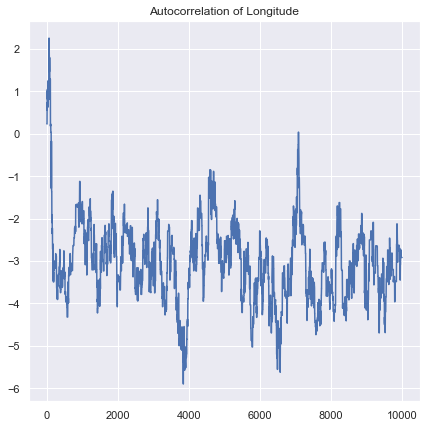

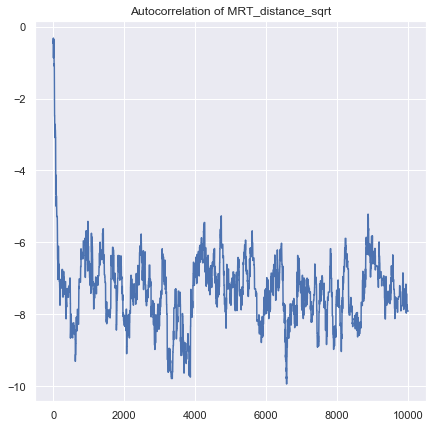

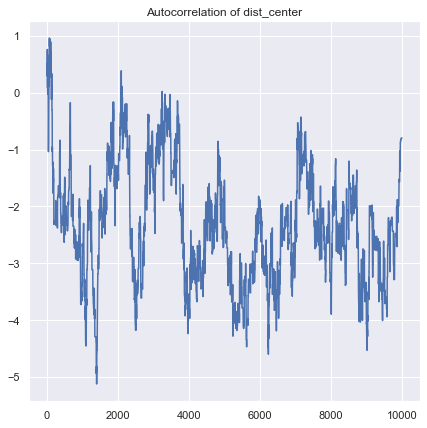

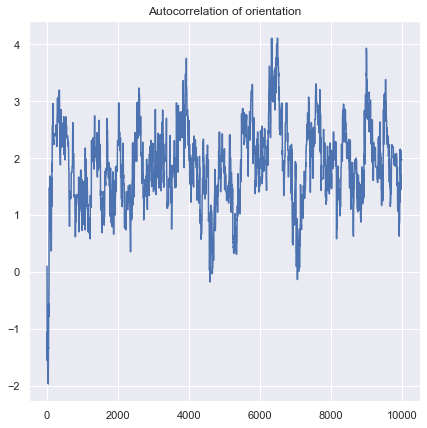

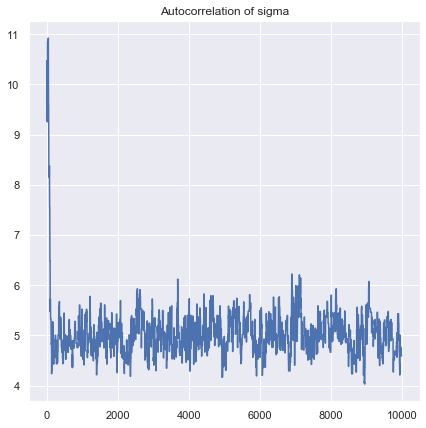

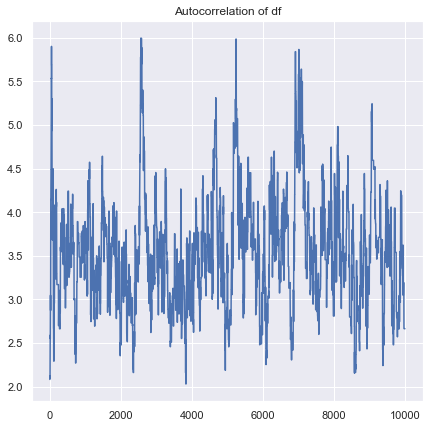

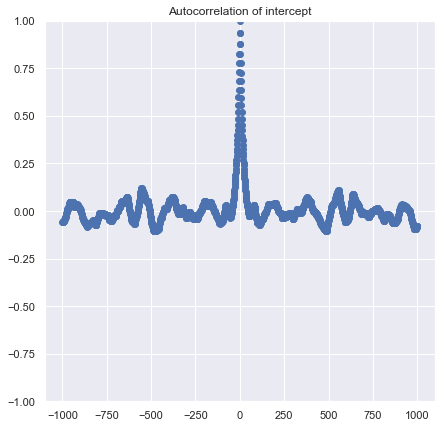

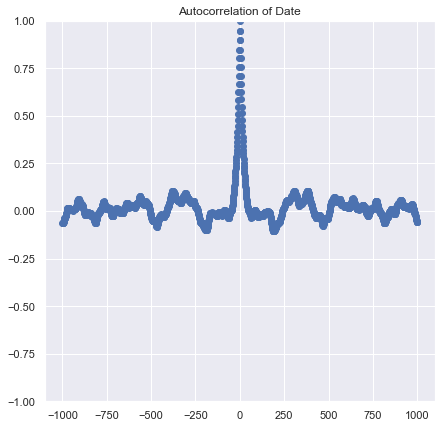

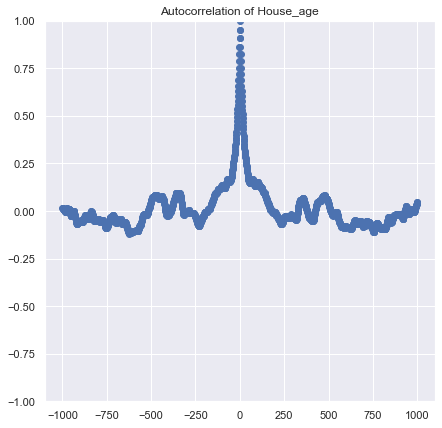

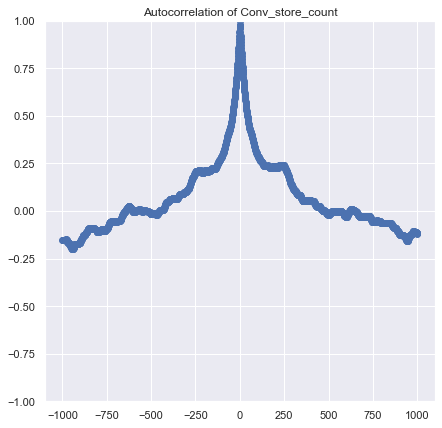

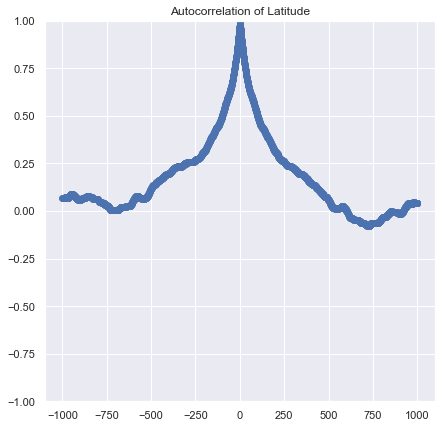

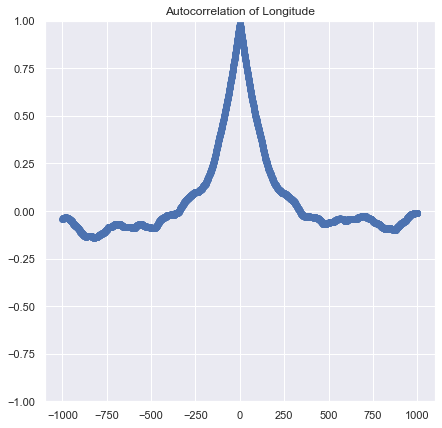

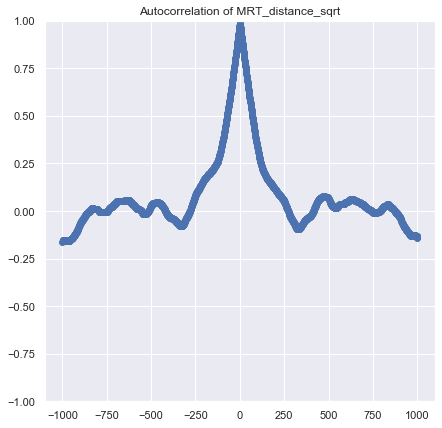

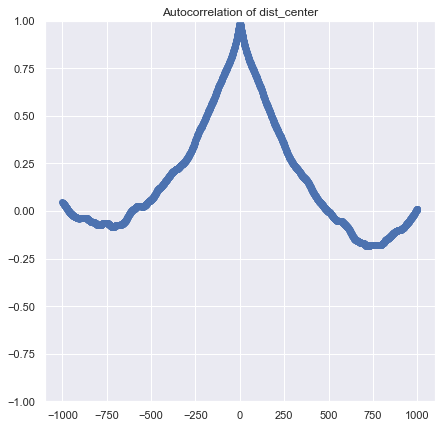

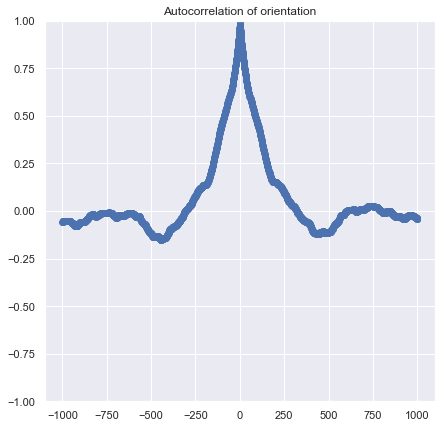

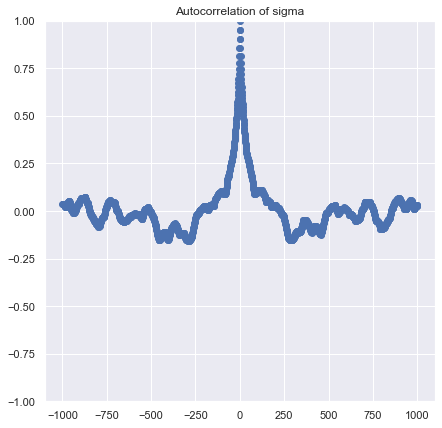

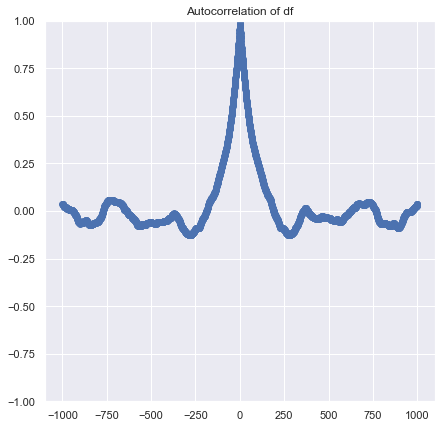

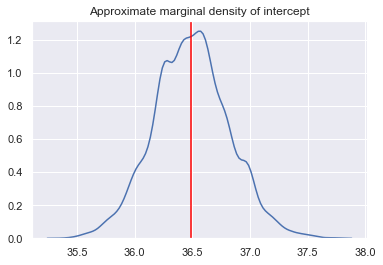

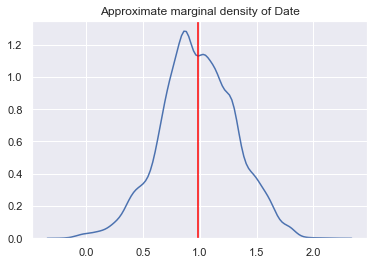

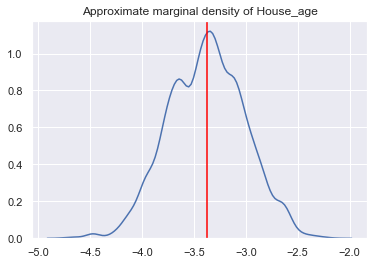

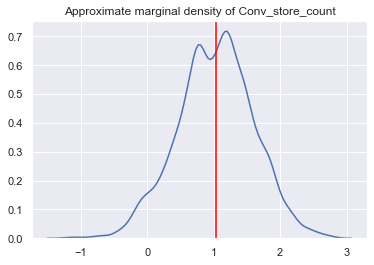

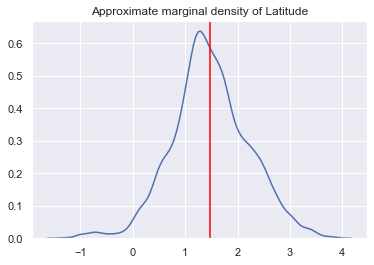

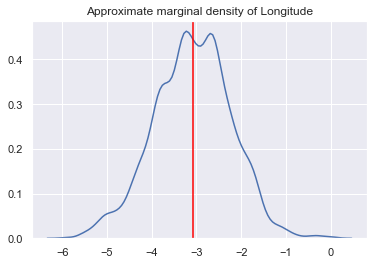

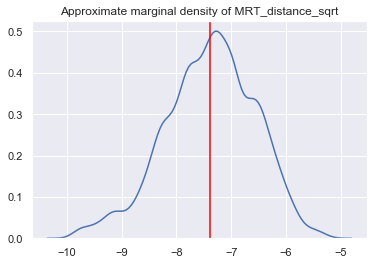

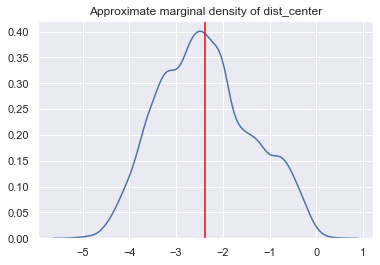

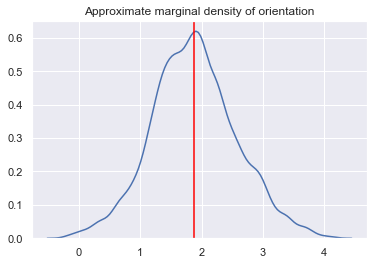

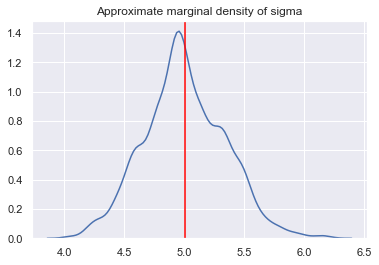

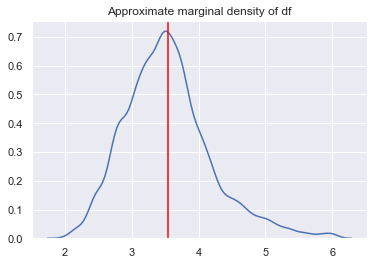

============ Fidelity summary ==================
 the mean square error is :  56.737412113939286
 MSE test is :  55.92390613972529
 PVE is  :  0.6665285771775149
 F   is  :  79.7869341712772
 p value :  1.1102230246251565e-16
 AIC is  :  2201.894339456975
 BIC is  :  2236.0588592138633
 AICc is :  2202.458602779859


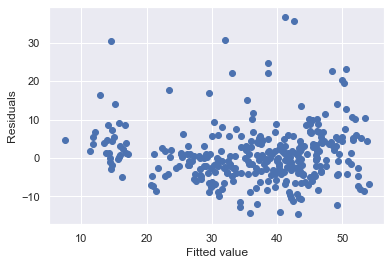

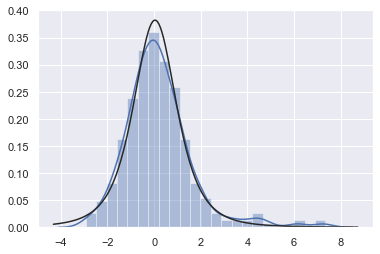

<Figure size 432x288 with 0 Axes>

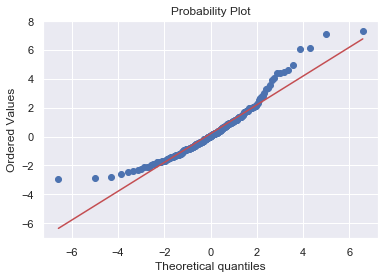

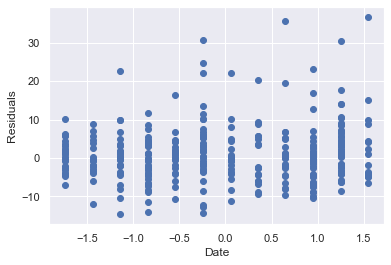

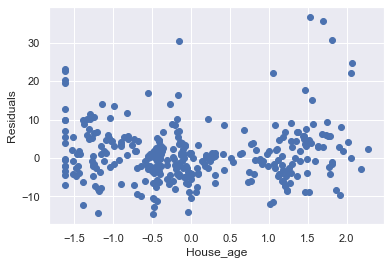

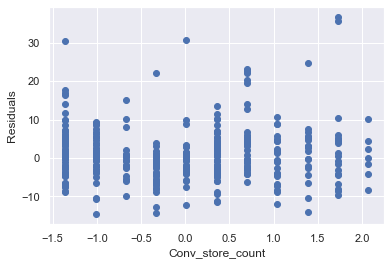

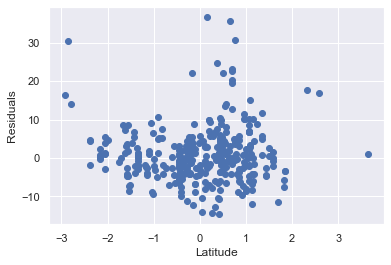

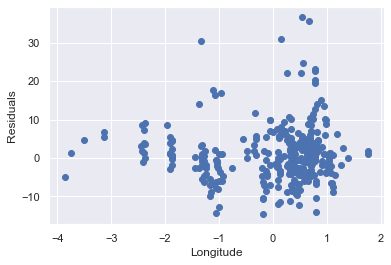

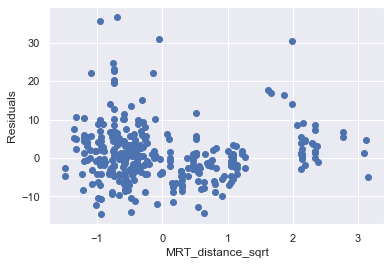

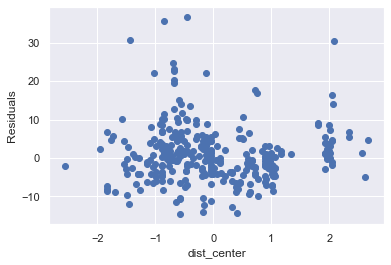

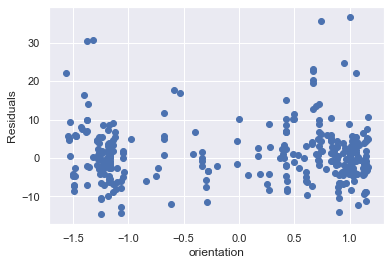

In [6]:
X = (data_no_outlier[X_names[1:-2]].dropna()).to_numpy()
Model_gaus = Bayesian_framework(len(X_names)-3,X_names,X,Y)
proba_set =  Student_model_np(Model_gaus)

# Define the model
Model_gaus.set_log_joint_prior(proba_set.log_joint_prior)
Model_gaus.set_log_likelihood(proba_set.log_likelihood)

# define a sample algorithm :
init = np.array( [30,0,0,0,0,0,0,0,0,10,2] )
step_size = 0.3
num_samples = 10000

M_H_gaus = Metropolis_hastings(Model_gaus,init ,step_size,num_samples)

M_H_gaus.compute_statistic()

# We see that we can select a burn in that around 200
burn_in = 500

M_H_gaus.compute_statistic(burn_in)
M_H_gaus.summary()
tool_gaus = Vizualisation_tool(Model_gaus,M_H_gaus)
tool_gaus.trace_visualization()
tool_gaus.autocorrelation_visualization()
tool_gaus.marginal_visualization()    
tool_gaus.fidelity()
tool_gaus.diagnostics(student = True)

**Remarks :**
 - We can see that **MRT_distance_sqrt** seems to be the best coefficient
 - Residual vs MRT_distance suggest that we can add the square of MRT_distance


In [9]:
X_names = [ 'intercept','MRT_distance_sqrt' ,'House_age','Latitude', 'Date'  ,'Conv_store_count','sigma','df' ]

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:33<00:00, 106.55it/s]


Acceptance rate :  0.3644
            features  Coeff   std                CI    2.5   25.0   50.0  \
0          intercept  36.60  0.35  [35.895, 37.303]  35.92  36.36  36.60   
1  MRT_distance_sqrt  -6.73  0.53  [-7.793, -5.671]  -7.80  -7.09  -6.73   
2          House_age  -3.15  0.36  [-3.862, -2.428]  -3.82  -3.39  -3.15   
3           Latitude   2.44  0.46    [1.512, 3.366]   1.56   2.13   2.42   
4               Date   0.99  0.36    [0.274, 1.702]   0.28   0.75   0.99   
5   Conv_store_count   2.04  0.48    [1.075, 3.000]   1.09   1.71   2.05   
6              sigma   5.44  0.36    [4.709, 6.164]   4.68   5.20   5.44   
7                 df   4.28  0.97    [2.340, 6.214]   2.70   3.56   4.15   

    75.0   97.5  
0  36.83  37.31  
1  -6.37  -5.71  
2  -2.92  -2.40  
3   2.74   3.42  
4   1.24   1.67  
5   2.36   2.97  
6   5.67   6.18  
7   4.89   6.45  


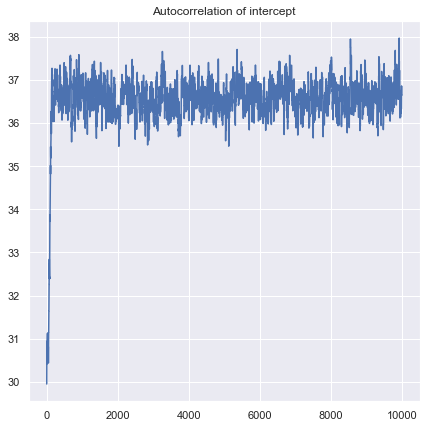

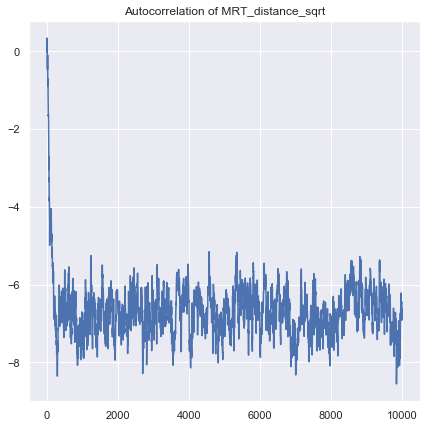

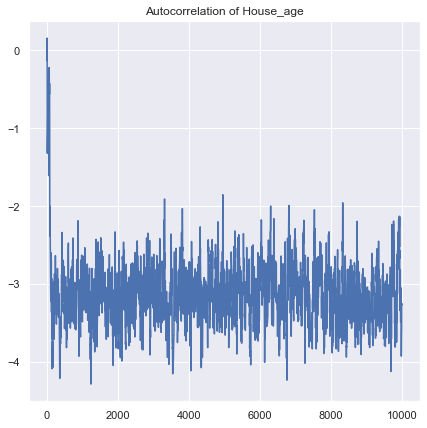

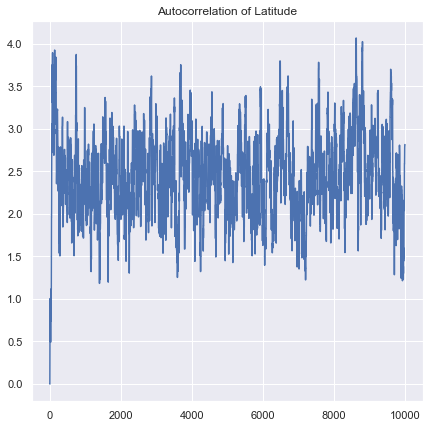

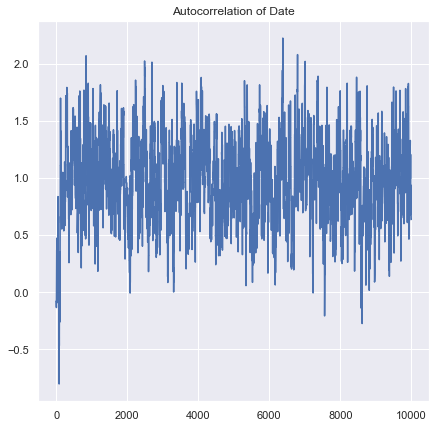

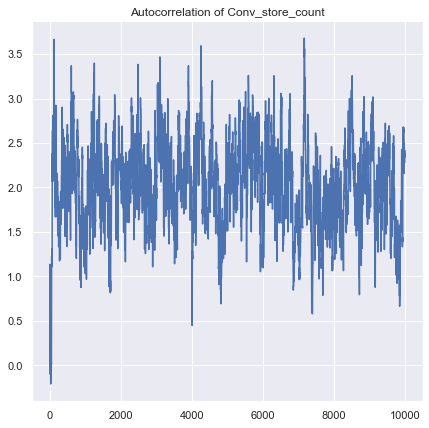

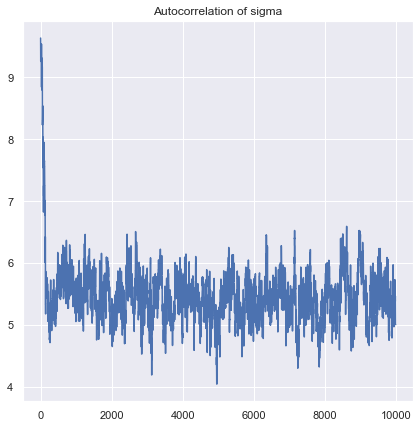

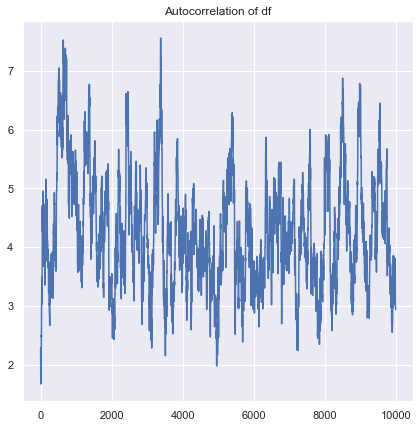

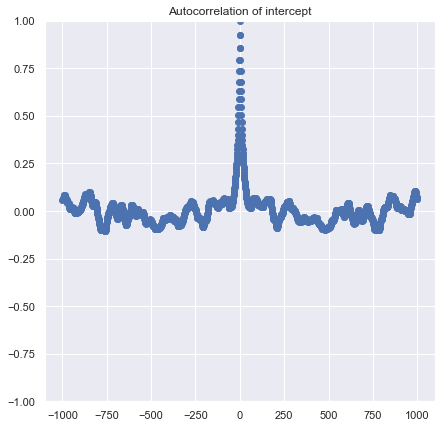

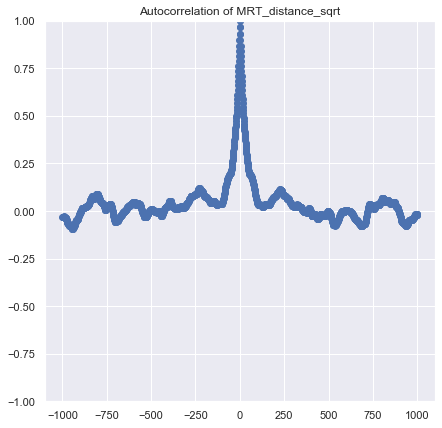

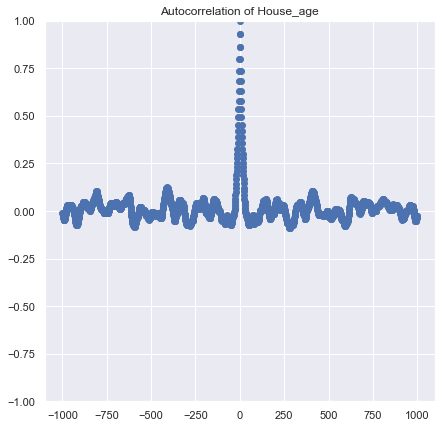

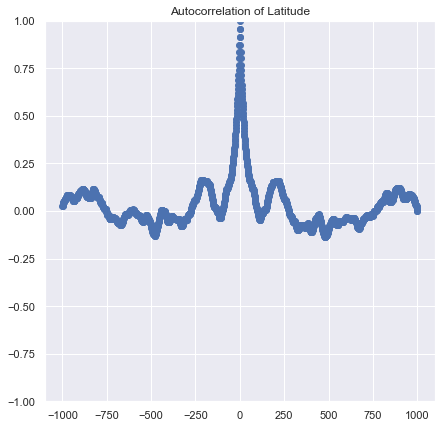

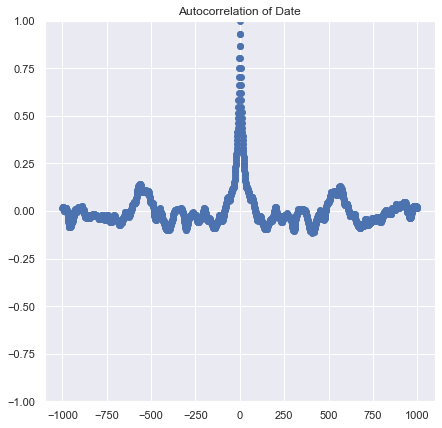

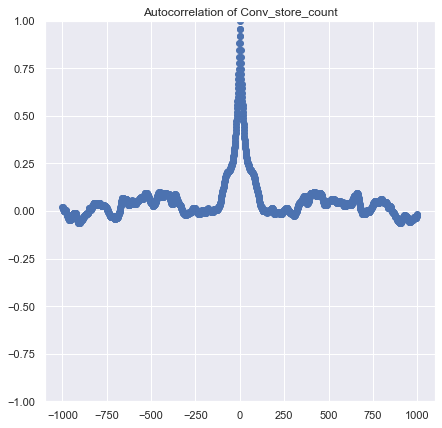

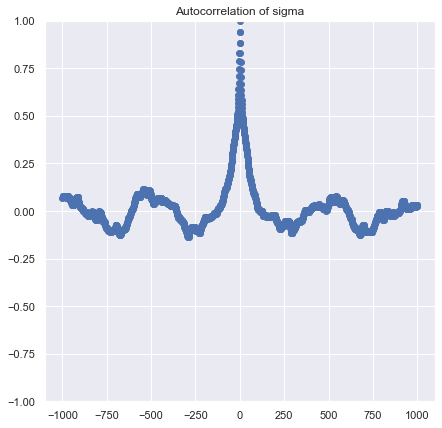

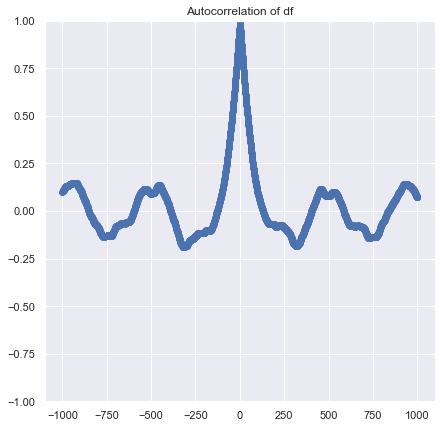

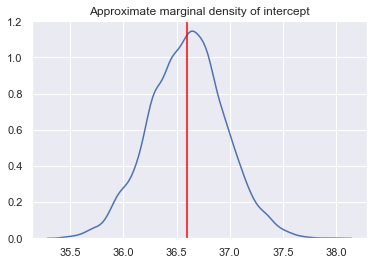

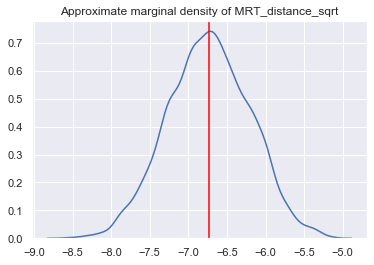

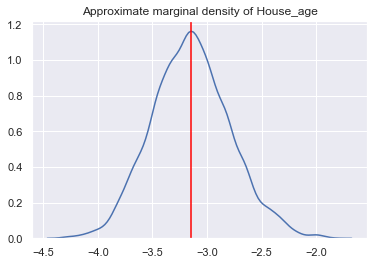

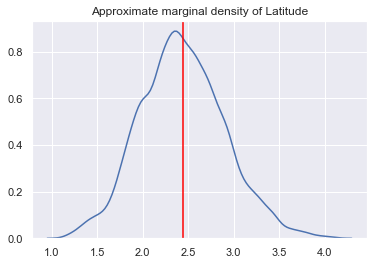

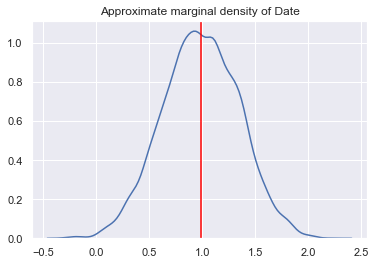

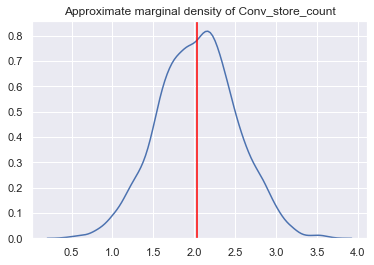

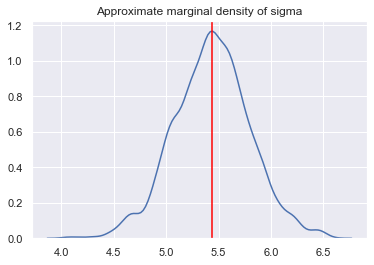

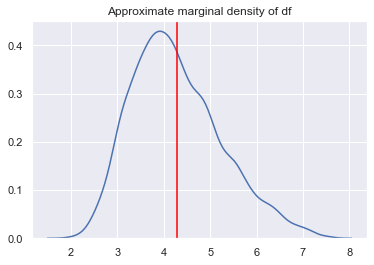

============ Fidelity summary ==================
 the mean square error is :  56.82569330198475
 MSE test is :  52.005578009747396
 PVE is  :  0.6556675121578469
 F   is  :  125.38380092492609
 p value :  1.1102230246251565e-16
 AIC is  :  2216.617870237937
 BIC is  :  2239.3942167425294
 AICc is :  2216.8787398031545


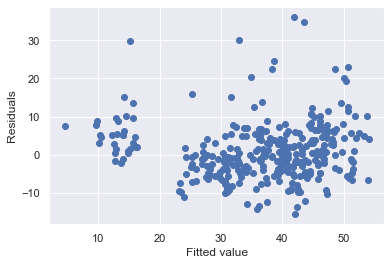

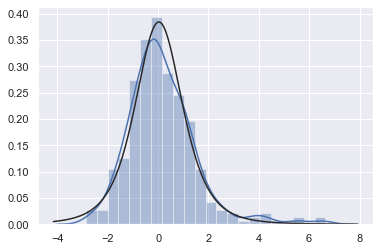

<Figure size 432x288 with 0 Axes>

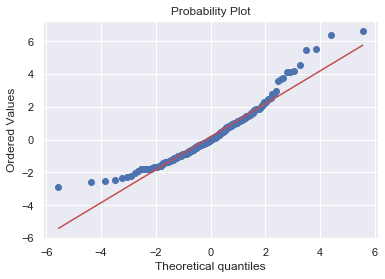

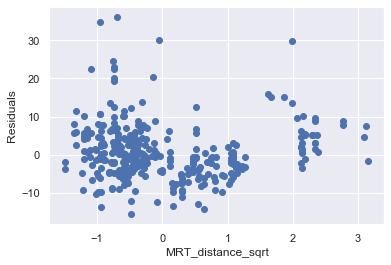

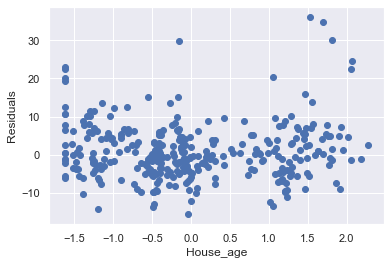

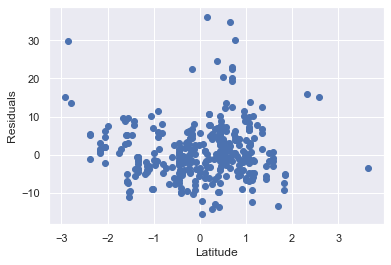

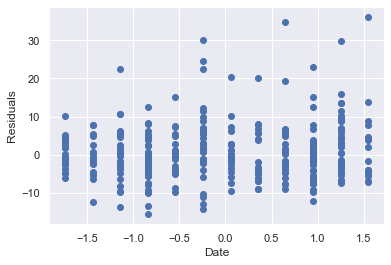

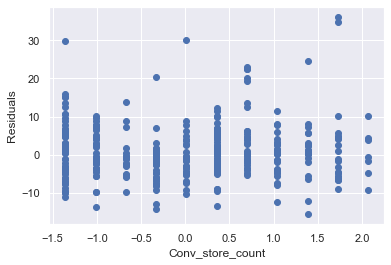

In [12]:
X = (data_no_outlier[X_names[1:-2]].dropna()).to_numpy()
Model_gaus = Bayesian_framework(len(X_names)-3,X_names,X,Y)
proba_set =  Student_model_np(Model_gaus)

# Define the model
Model_gaus.set_log_joint_prior(proba_set.log_joint_prior)
Model_gaus.set_log_likelihood(proba_set.log_likelihood)

# define a sample algorithm :
init = np.array( [30,0,0,0,0,0,10,2] )
step_size = 0.25
num_samples = 10000

M_H_gaus = Metropolis_hastings(Model_gaus,init ,step_size,num_samples)

M_H_gaus.compute_statistic()

# We see that we can select a burn in that around 200
burn_in = 500

M_H_gaus.compute_statistic(burn_in)
M_H_gaus.summary()
tool_gaus = Vizualisation_tool(Model_gaus,M_H_gaus)
tool_gaus.trace_visualization()
tool_gaus.autocorrelation_visualization()
tool_gaus.marginal_visualization()    
tool_gaus.fidelity()
tool_gaus.diagnostics(student = True)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:32<00:00, 107.69it/s]


Acceptance rate :  0.2774
            features  Coeff   std                  CI    2.5   25.0   50.0  \
0          intercept  36.75  0.33    [36.090, 37.406]  36.13  36.52  36.74   
1  MRT_distance_sqrt -16.38  1.60  [-19.585, -13.178] -19.13 -17.68 -16.38   
2       MRT_distance   9.53  1.53     [6.464, 12.601]   6.01   8.46   9.55   
3          House_age  -3.17  0.32    [-3.818, -2.521]  -3.82  -3.38  -3.16   
4           Latitude   3.25  0.43      [2.381, 4.115]   2.34   2.98   3.24   
5               Date   1.11  0.33      [0.458, 1.768]   0.48   0.88   1.12   
6   Conv_store_count   0.90  0.49     [-0.082, 1.877]  -0.12   0.57   0.90   
7              sigma   4.59  0.34      [3.906, 5.282]   3.98   4.34   4.56   
8                 df   3.27  0.64      [1.986, 4.554]   2.22   2.80   3.20   

    75.0   97.5  
0  36.99  37.38  
1 -15.21 -13.04  
2  10.76  12.06  
3  -2.94  -2.54  
4   3.56   4.06  
5   1.34   1.75  
6   1.24   1.82  
7   4.82   5.31  
8   3.68   4.81  


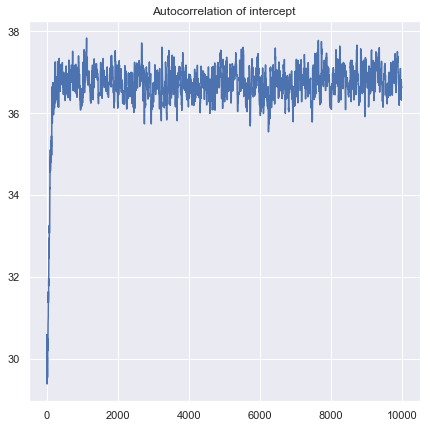

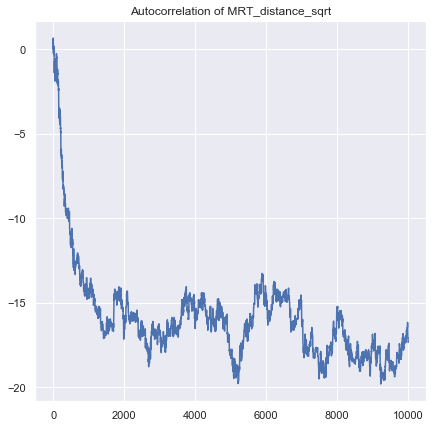

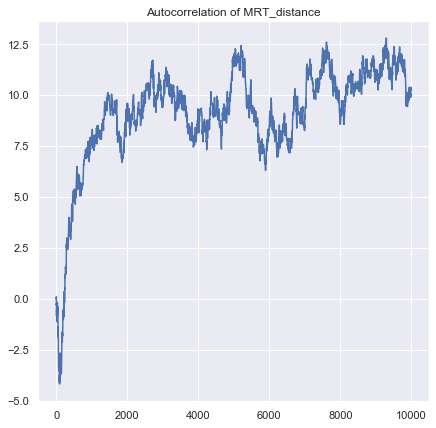

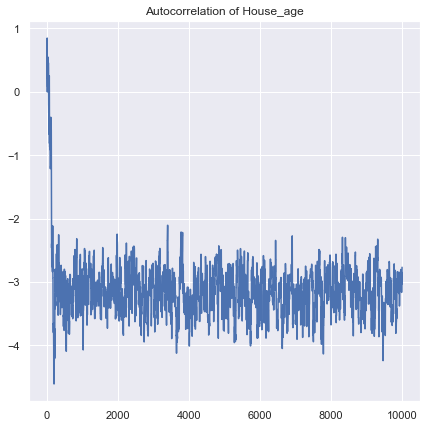

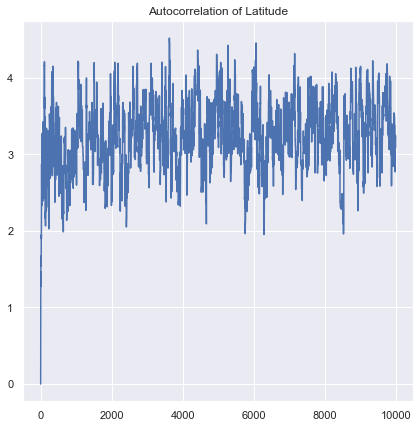

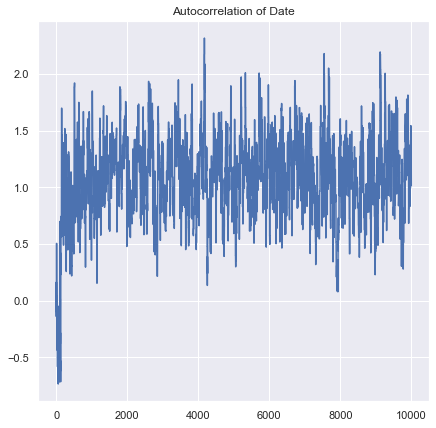

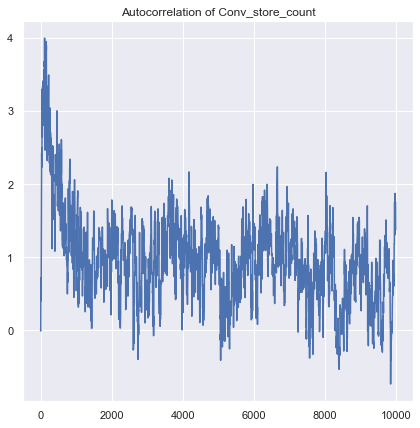

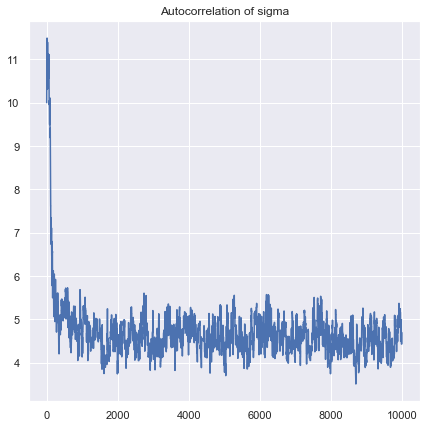

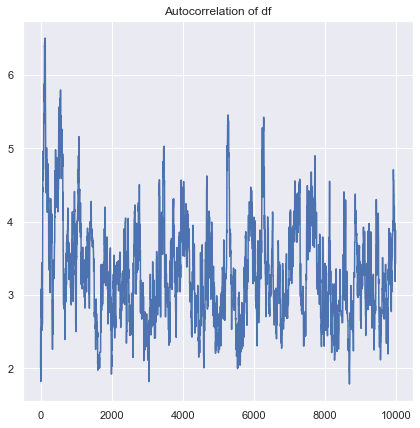

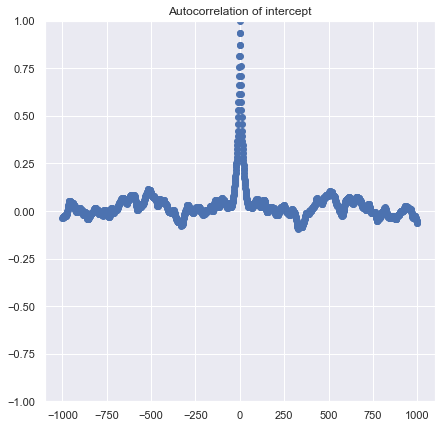

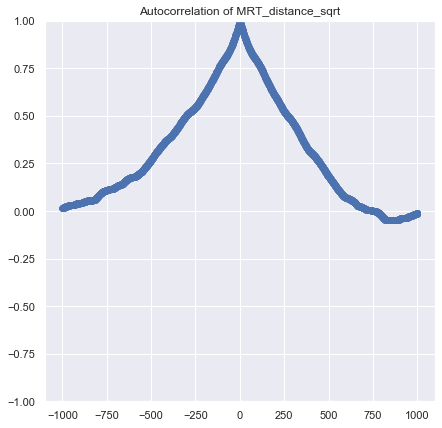

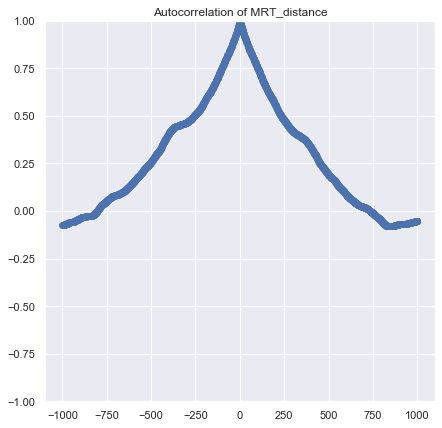

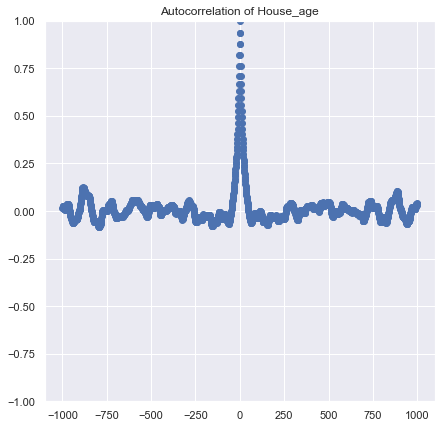

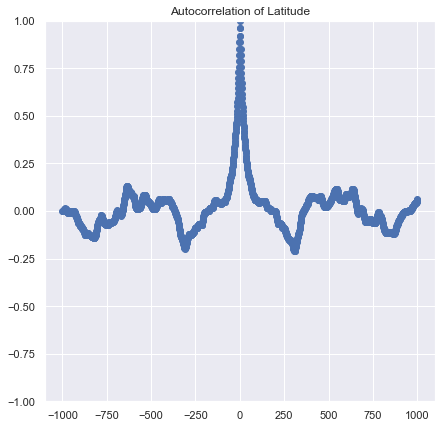

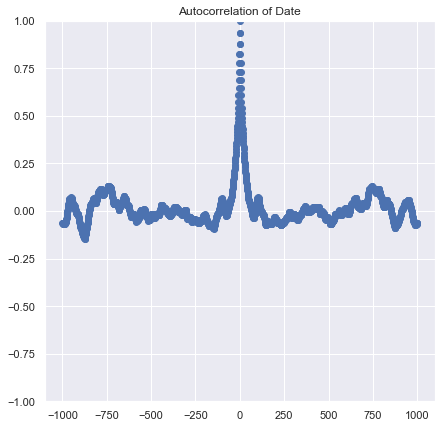

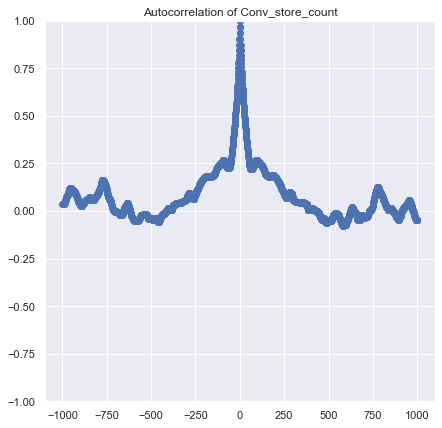

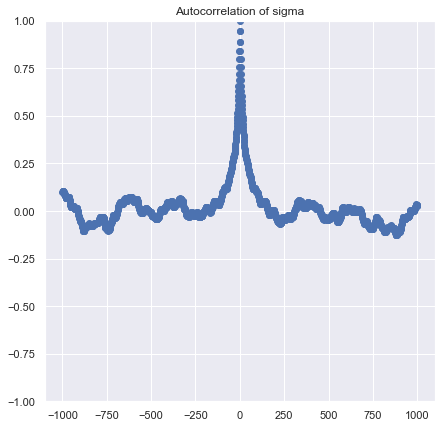

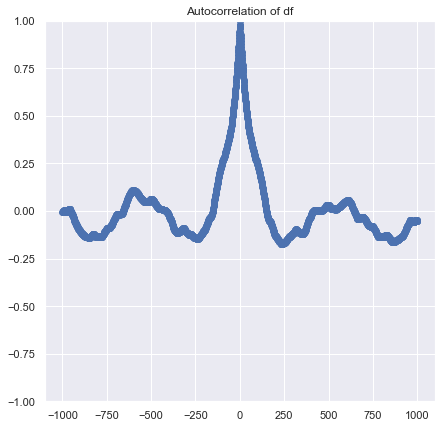

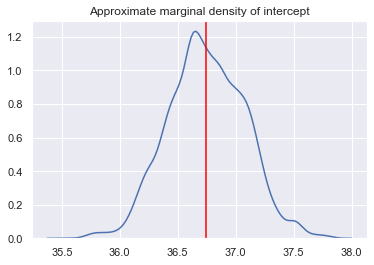

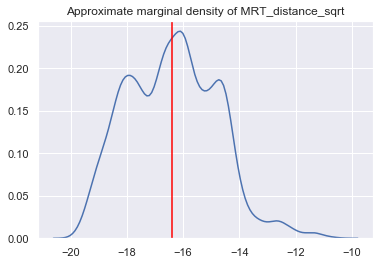

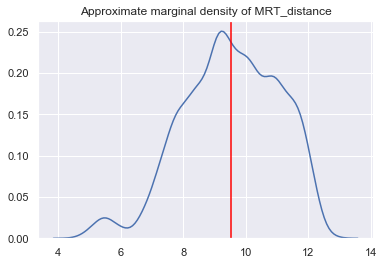

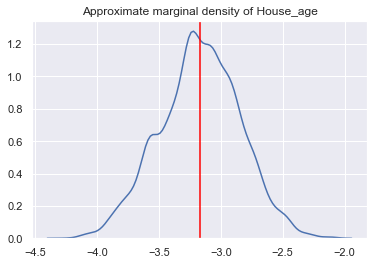

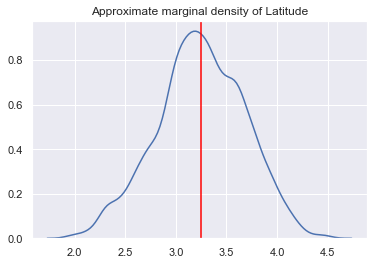

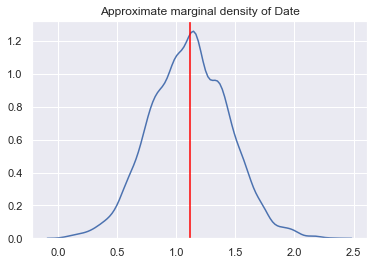

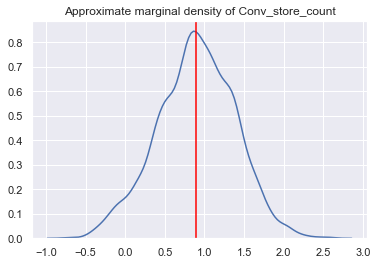

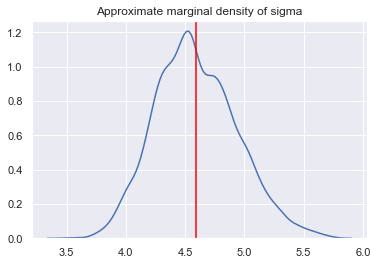

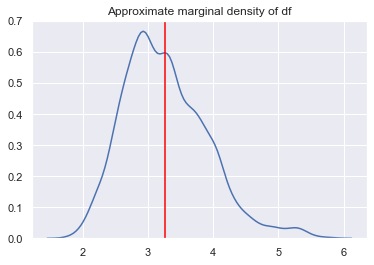

============ Fidelity summary ==================
 the mean square error is :  51.615276895125945
 MSE test is :  48.690187995903344
 PVE is  :  0.6848589722085433
 F   is  :  120.1556372437152
 p value :  1.1102230246251565e-16
 AIC is  :  2159.5567316097627
 BIC is  :  2186.12913586512
 AICc is :  2159.9056412670834


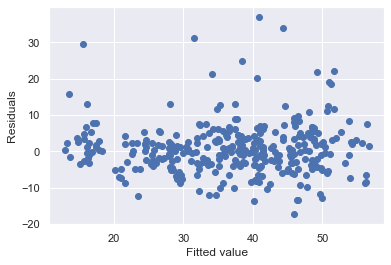

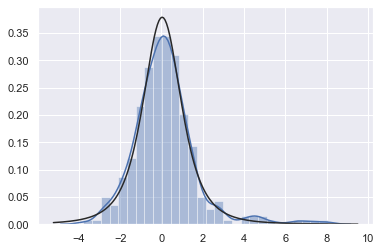

<Figure size 432x288 with 0 Axes>

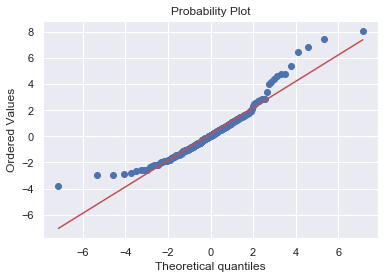

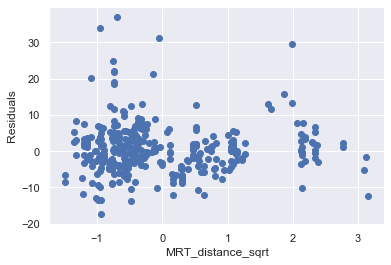

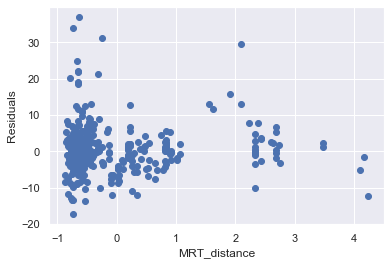

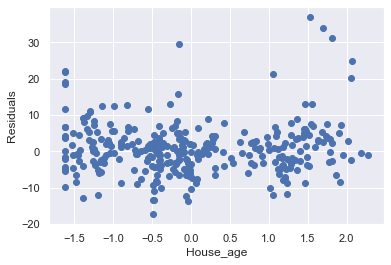

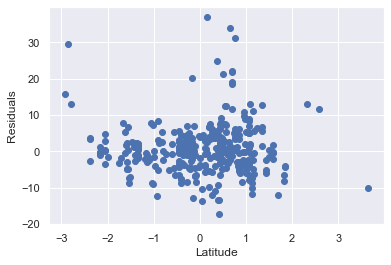

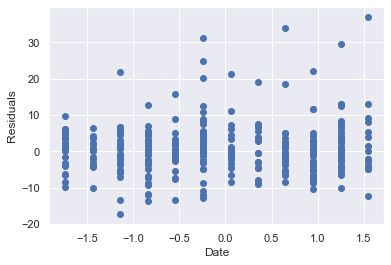

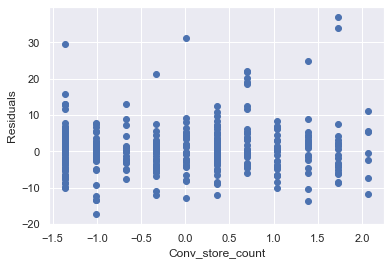

In [13]:
X_names = [ 'intercept','MRT_distance_sqrt' ,'MRT_distance','House_age','Latitude', 'Date'  ,'Conv_store_count','sigma','df' ]
X = (data_no_outlier[X_names[1:-2]].dropna()).to_numpy()
Model_gaus = Bayesian_framework(len(X_names)-3,X_names,X,Y)
proba_set =  Student_model_np(Model_gaus)

# Define the model
Model_gaus.set_log_joint_prior(proba_set.log_joint_prior)
Model_gaus.set_log_likelihood(proba_set.log_likelihood)

# define a sample algorithm :
init = np.array( [30,0,0,0,0,0,0,10,2] )
step_size = 0.25
num_samples = 10000

M_H_gaus = Metropolis_hastings(Model_gaus,init ,step_size,num_samples)

M_H_gaus.compute_statistic()

# We see that we can select a burn in that around 200
burn_in = 500

M_H_gaus.compute_statistic(burn_in)
M_H_gaus.summary()
tool_gaus = Vizualisation_tool(Model_gaus,M_H_gaus)
tool_gaus.trace_visualization()
tool_gaus.autocorrelation_visualization()
tool_gaus.marginal_visualization()    
tool_gaus.fidelity()
tool_gaus.diagnostics(student = True)

### Using GVA 





  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

 the loss is : tensor([1537.6160], grad_fn=<NegBackward>)
 the grad is : tensor([ -1.2367,  50.4731,  12.3369, -36.4125,   1.3886, -38.3303, -92.2537,
         25.5805])
 norm of the gradient  tensor(121.0925)






  0%|▎                                                                                 | 1/300 [00:03<16:17,  3.27s/it]

tensor([37.0348, -1.4207, -0.3473,  1.0249, -0.0391,  1.0789,  7.5967,  4.2800])






  1%|▌                                                                                 | 2/300 [00:06<16:00,  3.22s/it]



  1%|▊                                                                                 | 3/300 [00:09<15:59,  3.23s/it]



  1%|█                                                                                 | 4/300 [00:13<17:22,  3.52s/it]



  2%|█▎                                                                                | 5/300 [00:16<16:13,  3.30s/it]



  2%|█▋                                                                                | 6/300 [00:20<16:55,  3.45s/it]



  2%|█▉                                                                                | 7/300 [00:23<15:34,  3.19s/it]



  3%|██▏                                                                               | 8/300 [00:26<16:06,  3.31s/it]



  3%|██▍                                                                               | 9/300 [00:30<17:22,  3.58s/it]



  3%|██▋    

 the loss is : tensor([1147.9987], grad_fn=<NegBackward>)
 the grad is : tensor([0.2659, 0.7284, 0.2051, 0.1193, 0.1108, 0.2051, 0.6922, 0.1059])
 norm of the gradient  tensor(1.0965)






  4%|██▉                                                                              | 11/300 [00:37<17:27,  3.63s/it]

tensor([36.6633, -6.6273, -3.1730,  2.5437,  0.9976,  2.1225,  5.5578,  5.0710])






  4%|███▏                                                                             | 12/300 [00:41<17:20,  3.61s/it]



  4%|███▌                                                                             | 13/300 [00:46<18:42,  3.91s/it]

 Norm gradient < 0.5 stop 
 GVA method takes : 46.48  s to run 
            features  Coeff   std                CI        2.5       25.0  \
0          intercept  36.68  0.42  [35.847, 37.516]  35.860001  36.400002   
1  MRT_distance_sqrt  -6.65  0.67  [-8.000, -5.305]  -7.950000  -7.100000   
2          House_age  -3.15  0.38  [-3.914, -2.382]  -3.890000  -3.410000   
3           Latitude   2.52  0.48    [1.557, 3.484]   1.600000   2.190000   
4               Date   1.01  0.40    [0.209, 1.816]   0.220000   0.750000   
5   Conv_store_count   2.09  0.56    [0.965, 3.212]   0.990000   1.710000   
6              sigma   5.57  0.38    [4.810, 6.329]   4.820000   5.310000   
7                 df   5.02  1.08    [2.859, 7.173]   2.890000   4.290000   

    50.0       75.0   97.5  
0  36.68  36.959999  37.50  
1  -6.66  -6.200000  -5.30  
2  -3.15  -2.880000  -2.39  
3   2.52   2.840000   3.47  
4   1.01   1.280000   1.79  
5   2.08   2.470000   3.19  
6   5.58   5.830000   6.30  
7   5.01  

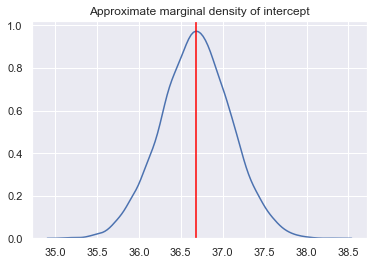

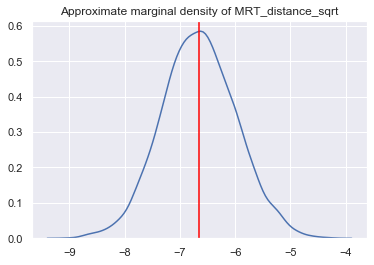

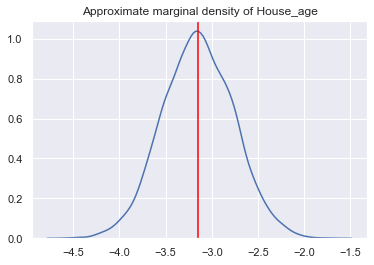

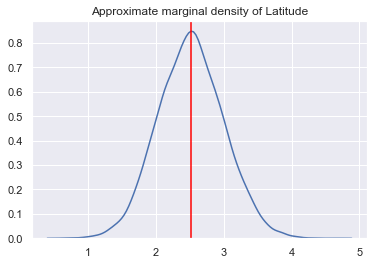

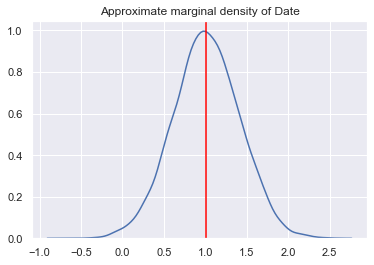

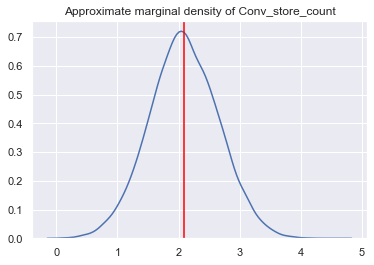

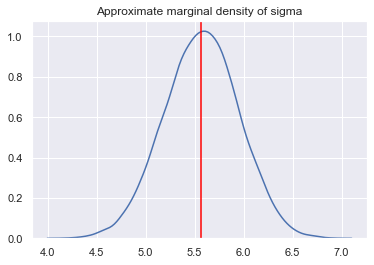

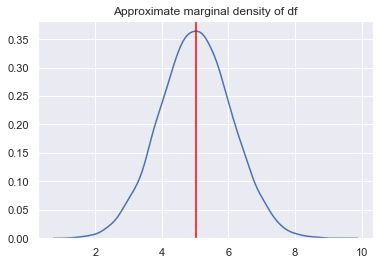

============ Fidelity summary ==================
 the mean square error is :  56.62238309506076
 MSE test is :  51.782956108868376
 PVE is  :  0.6568325438289403
 F   is  :  126.05759801582197
 p value :  1.1102230246251565e-16
 AIC is  :  2217.399198958762
 BIC is  :  2240.1755454633544
 AICc is :  2217.6600685239796


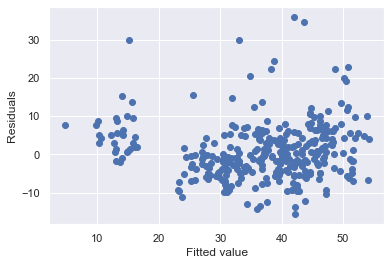

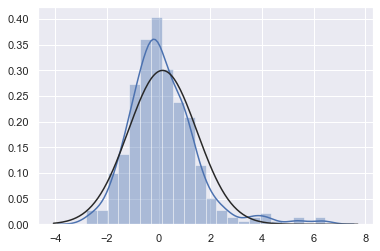

<Figure size 432x288 with 0 Axes>

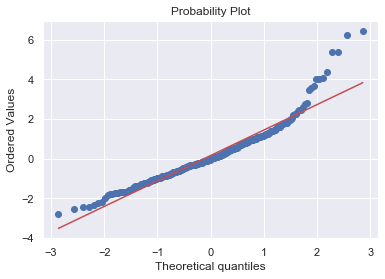

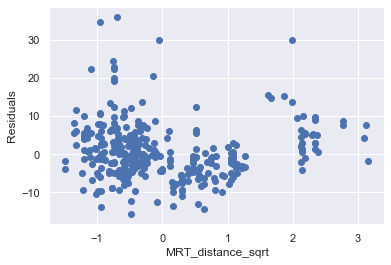

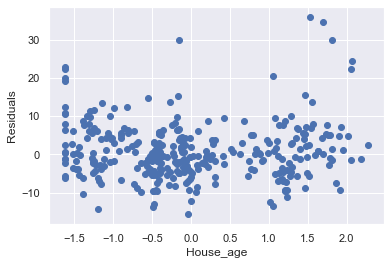

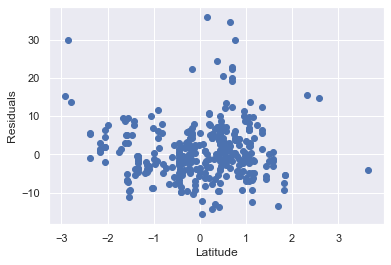

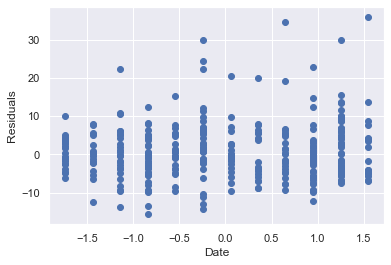

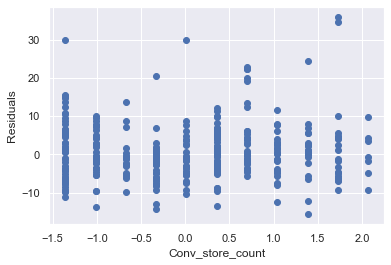

In [9]:
Parameter = [ 'intercept', 'MRT_distance_sqrt','House_age','Latitude', 'Date'  ,'Conv_store_count','sigma','df']
predictors = [  'MRT_distance_sqrt' ,'House_age','Latitude', 'Date'  ,'Conv_store_count']
X = (data_no_outlier[predictors].dropna()).to_numpy()
Model = Bayesian_framework(5,Parameter,X,Y,torch_imp=True)
proba_set = Student_model_gaussian_prior_torch(Model)

# Define the model
Model.set_log_joint_prior(proba_set.log_joint_prior)
Model.set_log_likelihood(proba_set.log_likelihood)

# define a sample algorithm :
gva = GVA(Model)
init_mu = torch.zeros(8)
init_mu[0]= 37
init_mu[-2] = 5
init_mu[-1] = 5
init_L = -2*torch.ones(8,8)
gva.compute_GVA_algo(init_mu,init_L, step_size = 0.07, show = True , line_search = True , stop_crit = 0.5)

tool = Vizualisation_tool(Model,gva)
tool.marginal_visualization()    
tool.fidelity()
tool.diagnostics()

### Using important sampling 

tensor([2279.9537], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1797.3303], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1608.5308], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1490.2522], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1361.8502], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1206.9069], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1183.0151], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1157.6318], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1154.5550], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1153.1174], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1152.6748], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1152.4063], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1152.2017], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1151.9847], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1151.7968], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1151.5978], dtype=torch.float64,

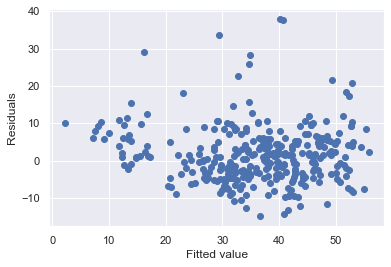

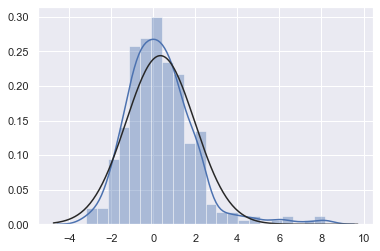

<Figure size 432x288 with 0 Axes>

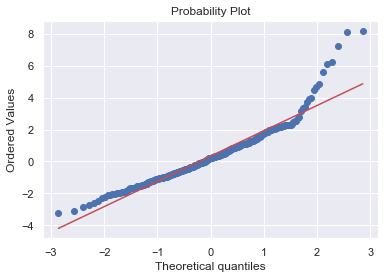

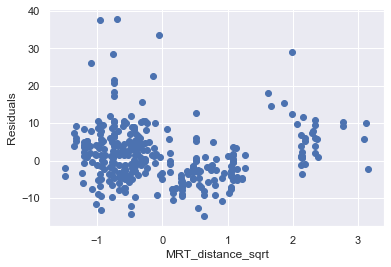

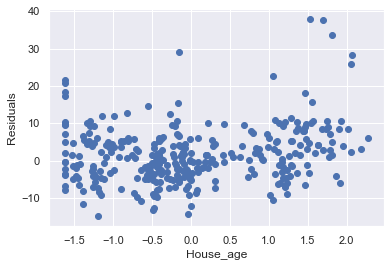

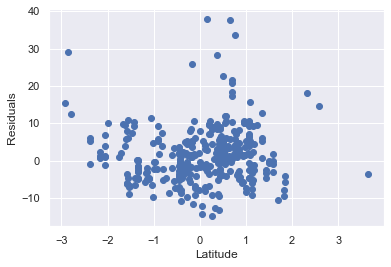

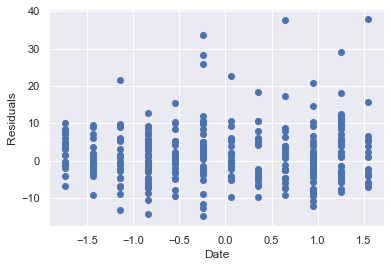

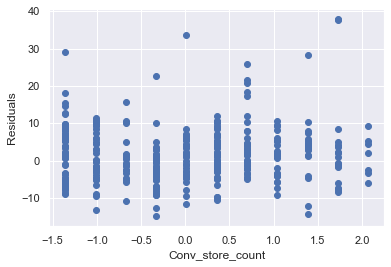

In [10]:
Parameter = [ 'intercept', 'MRT_distance_sqrt','House_age','Latitude', 'Date'  ,'Conv_store_count','sigma','df']
predictors = [  'MRT_distance_sqrt' ,'House_age','Latitude', 'Date'  ,'Conv_store_count']
X = (data_no_outlier[predictors].dropna()).to_numpy()
Model = Bayesian_framework(5,Parameter,X,Y,torch_imp=True)
proba_set = Student_model_gaussian_prior_torch(Model)

# Define the model
Model.set_log_joint_prior(proba_set.log_joint_prior)
Model.set_log_likelihood(proba_set.log_likelihood)

# define a sample algorithm :
imp_s = Important_sampling(Model)
mean_proposal = imp_s.compute_mode_algo( line_search = True)
cov_mat = 0.5*np.ones(8)
proposal = st.multivariate_normal(mean = mean_proposal.view(-1).numpy() , cov = np.diag(cov_mat))
w,theta = imp_s.compute_algo(proposal , 1000000)
imp_s.compute_statistic()
imp_s.summary()

tool = Vizualisation_tool(Model,imp_s)
tool.fidelity()
tool.diagnostics()